In [17]:
import itertools
import json
import numpy as np
import matplotlib.pyplot as plt
from skimage import color
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, confusion_matrix, accuracy_score

# A. Importar datos

Los datos vienen en un archivo **.json**, con la siguientes llaves:

- `data`: list of list[int], imagenes 80x80 RGB, las imagenes estan aplanadas en un vector de dimensión 19200 (80x80x3),  las primeras 6400 entradas contienen los valores del canal rojo, las siguientes 6400 del verde, y las últimas 6400 del azul. La imagen es almacenada en orden fila, asi las primeras 80 entradas del arreglo son los valores del canal rojo de la primera fila de la imagen.
- `labels`: list of int, etiquetas de las imágenes, donde 1->"ship", 0->"no-ship".
- `locations`**(irrelevante)**: list of tuples, coordenadas geográficas, longitud y latitude del punto central de cada imágen.
- `scene_ids`: list, identificador único de cada imágen.


In [18]:
# cargar datos
with open("shipsnet.json", "r") as f:
    dataset = json.load(f)
print(dataset.keys())

dict_keys(['data', 'labels', 'locations', 'scene_ids'])


Dimensión: (4000, 80, 80, 3)


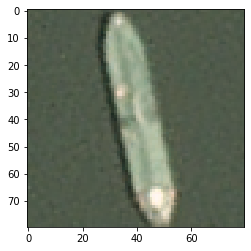

In [19]:
# llevar las imagenes aplanadas a 80x80x3
data = np.array(dataset['data']).astype('uint8')
data = data.reshape(-1,3,80,80).transpose([0,2,3,1])
labels =  np.array(dataset['labels'])

print(f"Dimensión: {data.shape}")

# ejemplos
plt.imshow(data[51])

In [20]:
 plt.figure(figsize=(10,3))

<Figure size 720x216 with 0 Axes>

<Figure size 720x216 with 0 Axes>

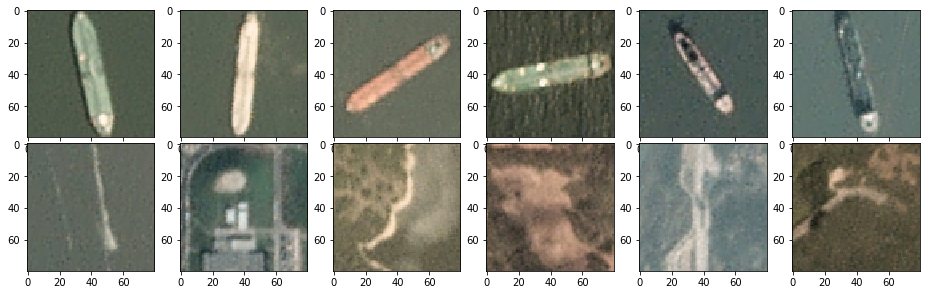

In [21]:
# ejemplos
f = plt.figure(figsize=(16,9))
for i in range(1,7):
    ax = f.add_subplot(2,6,i)
    ax.imshow(data[50+i])
for i in range(1,7):
    ax = f.add_subplot(1,6,i)
    ax.imshow(data[-1-i])

Dimensión: (4000, 80, 80)


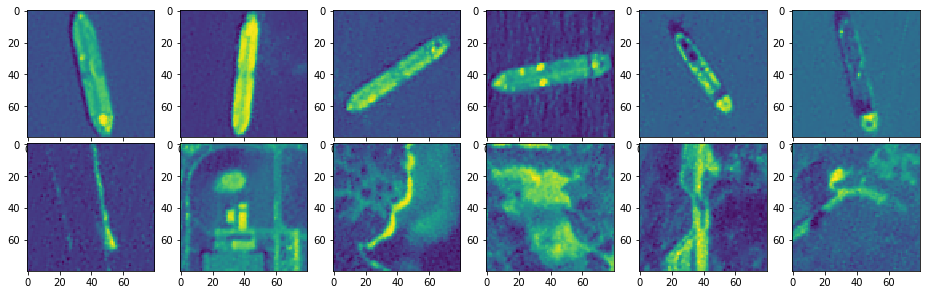

In [22]:
# llevamos las imágenes RGB a escala de grises
data_gray = np.array([color.rgb2gray(i) for i in data])
print(f"Dimensión: {data_gray.shape}")
# ejemplos
f = plt.figure(figsize=(16,9))
for i in range(1,7):
    ax = f.add_subplot(2,6,i)
    ax.imshow(data_gray[50+i])
for i in range(1,7):
    ax = f.add_subplot(1,6,i)
    ax.imshow(data_gray[-1-i])

The following figure illustrates the process. We are looking at magnitude and direction of the gradient of the same 8×8 patch as in the previous figure. A bin is selected based on the direction, and the vote ( the value that goes into the bin ) is selected based on the magnitude. Let’s first focus on the pixel encircled in blue. It has an angle ( direction ) of 80 degrees and magnitude of 2. So it adds 2 to the 5th bin. The gradient at the pixel encircled using red has an angle of 10 degrees and magnitude of 4. Since 10 degrees is half way between 0 and 20, the vote by the pixel splits evenly into the two bins.

# B. Extracción de características

## Histograms of Gradients (HoG) (lectura opcional)

EL histograma de orientación de gradiente (HoG) es un descriptor de características usado en visión por computadora y procesamiento de imágenes para la detección de objetos. Su utilidad viene dada de que la magnitud del gradiente es grande alrededor de los bordes y esquinas (regiones con cambios abruptos de itensidad), donde los arcos y esquinas contienen mucha más información sobre la forma del objeto que las regiones planas.

Sea $I_{i,j}$ la intensidad del pixel $(i,j)$, luego la magnitud del gradiente y su orientación viene dada por la siguiente expresión:

\begin{align}
& g = \sqrt{g_x^2+g_y^2}, g_x = I_{i,j}-I_{i-1,j}, g_y = I_{i,j}-I_{i,j-1}\\
& \theta = \text{arctan}\frac{gx}{gy}
\end{align}


Así el output inicial del procedemiento son dos matrices, una matriz que contiene la magnitud del gradiente de cada pixel y otra con la orientación del gradiente. Para convertir estas matrices a un vector se utilizará un histograma, por ejemplo, podemos dividir el dominio de las orientaciones en 9 bins de 20° (180° total, no son 360° ya que las transiciones de negro a blanco y de blanco a negro se consideran equivalentes), obteniéndose así un vector de dimensión 9, es decir, [0, 20, 40, 60, 80, 100, 120, 140, 160]. Luego cada pixel de una imágen votará en estos bins en base a la magnitud de gradiente que posee y su cercanía a los bins según su orientación, por ejemplo, si tenemos un pixel con ángulo 10° y magnitud 4, este sumára 2 al bin 0° y 2 al bin 20° pues se encuentra justo a la mitad de ambos, por otro lado, si tenemos un pixel con ángulo 80° y magnitud 2 este sumará solo al bin 80°. 

<img src="hog_histogram.png">

Para capturar de mejor forma información local de la imagen se suele dividir en zonas y calcular HoG en cada una de estas, siendo el vector resultante la concatenación de todos los histogramas. En el ejemplo a continuación la imágen se divide en 4x4 (16 submatrices, viene de dividir 80x80/(20x20)) y para cada zona se calcula HoG con 8 bins. 

Más detalle en:

- https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_hog.html?highlight=hog
- https://www.learnopencv.com/histogram-of-oriented-gradients/

In [23]:
# extrae hog features y hog transformation para cada imagen
ppc = 20
hog_images = []
hog_features = []
for image in data_gray:
    fd,hog_image = hog(image, orientations=8, pixels_per_cell=(ppc,ppc), cells_per_block=(1, 1),block_norm= 'L2',visualize=True)
    hog_images.append(hog_image)
    hog_features.append(fd)
hog_features = np.array(hog_features)
hog_images = np.array(hog_images)

hog_features.shape

(4000, 128)

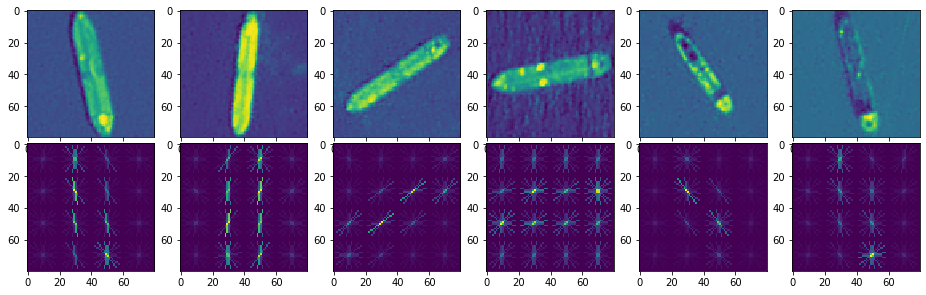

In [24]:
# ejemplos
f = plt.figure(figsize=(16,9))
for i in range(1,7):
    ax = f.add_subplot(2,6,i)
    ax.imshow(data_gray[50+i])
for i in range(1,7):
    ax = f.add_subplot(1,6,i)
    ax.imshow(hog_images[50+i])

# C. División en train-test y métricas

In [158]:
X, X_test, y, y_test = train_test_split(hog_features, labels, test_size=0.15, random_state=1, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15/(0.7+0.15), random_state=1, shuffle=True)

In [26]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    Dibuja la matriz de confusión junto a los valores con y sin normalización 
    
    Input
        cm: numpy array [int], 
            matriz de confusión no normalizada.
        classes: numpy array [int],
            identificador entero de las clases en orden creciente.
        title: str,
            titulo del plot,
        cmap: matplotlib.colors.Colormap,
            mapa de color usado para colorear la matriz de confusión.
    """
    fig = plt.figure(figsize=(8,8))
    plt.title(title, figure=fig)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, figure=fig)
    plt.yticks(tick_marks, classes, figure=fig)

    # matriz de confusión normalizada
    ncm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = 0.5
    for i, j in itertools.product(range(ncm.shape[0]), range(ncm.shape[1])):
        plt.text(j, i, str(round(100*ncm[i, j],2))+"%",
                 horizontalalignment="center",
                 color="white" if ncm[i, j] > thresh else "black",
                 fontsize=12, figure=fig)
        plt.text(j, i+0.1, str(cm[i, j]),
                 horizontalalignment="center",
                 color="black",
                 fontsize=10, figure=fig)

    plt.imshow(ncm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1, figure=fig)

    plt.colorbar()

    plt.tight_layout()
    plt.ylabel('True label',figure=fig)
    plt.xlabel('Predicted label',figure=fig)
    plt.close(fig)
    return fig

def get_cm(true_labels, predicted_labels):
    """
    Retorna un plot con la matriz de confusión y el accuray
    Input
        true_labels: numpy array
        predicted_labels: numpy array
    """
    # calcular matriz de confusión
    labels = np.unique(predicted_labels)
    cm = confusion_matrix(true_labels, predicted_labels, labels=labels)
    # figura con la matriz de confusión
    cm_fig = plot_confusion_matrix(cm, labels)
    # calcular accuracy
    acc = accuracy_score(true_labels, predicted_labels)
    return cm_fig, acc

# D. Entrenamiento y evaluación

### Logistic Regression

In [176]:
class MyLogisticRegression:
    def __init__(self, eta=0.1, n_iter=10000):
        self.eta = eta
        self.n_iter = n_iter    
     
    def fit(self, X, y):
        """
        En base al conjunto de entrenamiento D={X,y}, 
        despejar w y guardar en un atributo del objeto.
        """
        N, M = X.shape
        w = np.zeros(M)
        for i in range(self.n_iter):
            r = np.dot(X, w)
            sigma = 1/(1+np.exp(-r))
            grad = ((X.T*(y-sigma)).T).sum(axis=0)
            w = w+self.eta*grad
        self.w = w
    def predict(self, X):
        """
        Retorna las predicciones sobre X.
        """
        probabilities = 1/(1+np.exp(-np.dot(X, self.w)))
        predictions = probabilities.round()
        return predictions

In [177]:
clf = MyLogisticRegression()
clf.fit(X_train,y_train)

/home/dgarrido/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


/home/dgarrido/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in exp


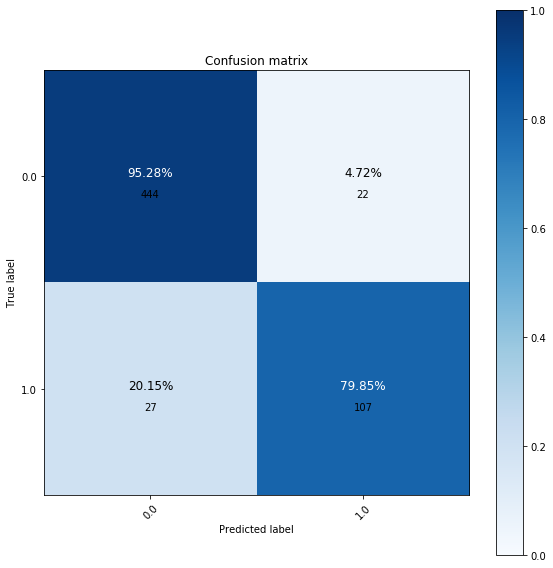

In [178]:
y_pred = clf.predict(X_val)
cm_fig, acc = get_cm(y_val, y_pred)
cm_fig

In [179]:
clf = MyLogisticRegression()
etas = np.linspace(0.01, 1, num=100)
metrics = np.zeros(len(etas))
for i, eta in enumerate(etas):
    clf.eta = eta
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_val)
    macro_recall = recall_score(y_val, y_pred, average="macro")
    metrics[i] = macro_recall

/home/dgarrido/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/home/dgarrido/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in exp


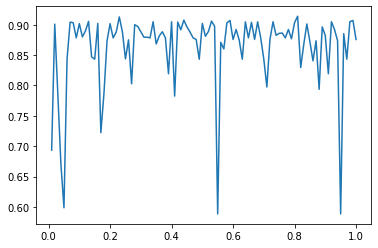

In [181]:
plt.plot(etas, metrics)

In [191]:
# eta con mejor desempeño en validación
clf = MyLogisticRegression()
eta = etas[metrics.argmax()]
clf.eta = eta
clf.fit(X_train, y_train)

/home/dgarrido/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


/home/dgarrido/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in exp


Macro Recall: 0.9275568181818181


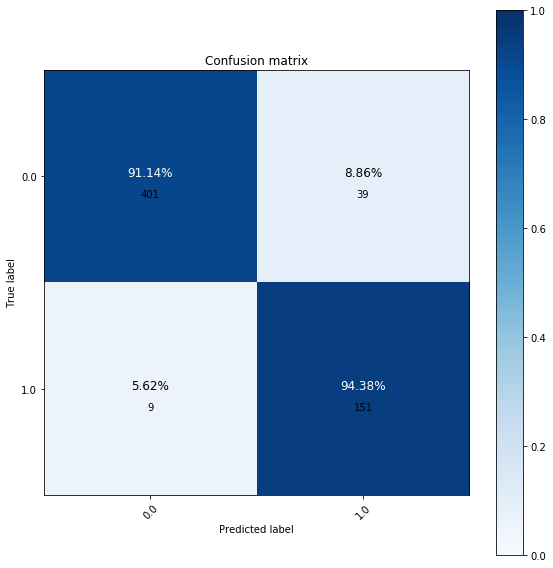

In [192]:
# desempeño en test
y_pred = clf.predict(X_test)
cm_fig, acc = get_cm(y_test, y_pred)
macro_recall = recall_score(y_test, y_pred, average="macro")
print(f"Macro Recall: {macro_recall}")
cm_fig

### FLDA

In [163]:
class MyFLDA:
    def fit(self, X, y):
        """
        En base al conjunto de entremamiento D={X,y},
        despejar a y b y guardar los atributos del objeto
        """
        N, M = X.shape
        N1 = y.sum()
        N2 = N-N1
        mu1 = ((X.T*y).T).sum(axis=0)/N1
        mu2 = ((X.T*(1-y)).T).sum(axis=0)/N2
        SB = np.dot((mu1-mu2).reshape((M,1)), (mu1-mu2).reshape((M,1)).T)
        SW = np.dot((X-mu1).T*y,((X-mu1).T*y).T)+np.dot((X-mu2).T*(1-y),((X-mu2).T*(1-y)).T)
        SW_inv = np.linalg.inv(SW)
        a = np.dot(SW_inv, mu1-mu2)
        b = -np.dot(a, (1/2)*(mu1+mu2))
        self.a = a
        self.b = b
    def predict(self, X):
        """
        Retorna las predicciones sobre X.
        """
        probabilities = 1/(1+np.exp(-(np.dot(X, self.a)+self.b)))
        predictions = probabilities.round()
        return predictions

In [164]:
clf = MyFLDA()
clf.fit(X_train, y_train)

Macro Recall: 0.8831112676958555


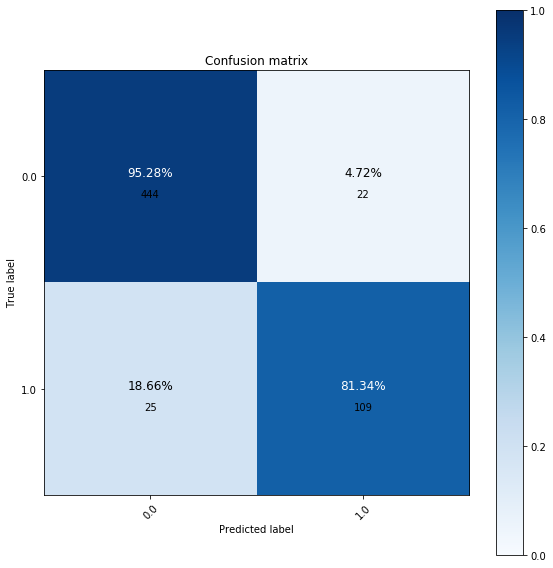

In [165]:
# desempeño en validación
y_pred = clf.predict(X_val)
cm_fig, acc = get_cm(y_val, y_pred)
macro_recall = recall_score(y_val, y_pred, average="macro")
print(f"Macro Recall: {macro_recall}")
cm_fig

Macro Recall: 0.9224431818181817


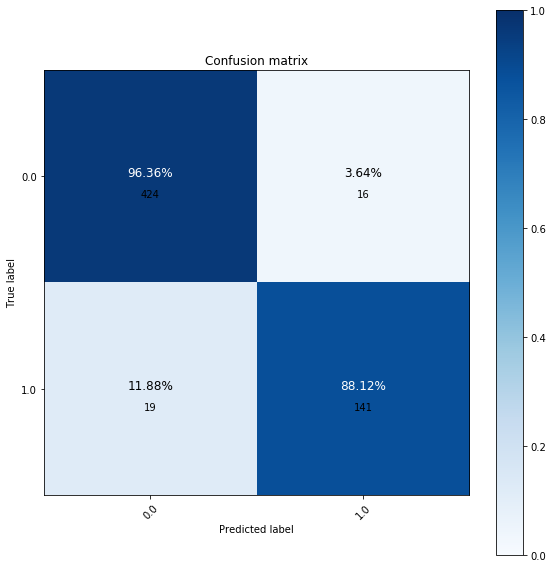

In [166]:
# desempeño en validación
y_pred = clf.predict(X_test)
cm_fig, acc = get_cm(y_test, y_pred)
macro_recall = recall_score(y_test, y_pred, average="macro")
print(f"Macro Recall: {macro_recall}")
cm_fig